**What's in this notebook?** This notebook illustrates how to reproduce the historgams of Fig. 21 of the paper.

(*Created:* Andreas Schachner, June 18, 2024)

# Imports

In [1]:
### IMPORT
import sys, os, csv, time, warnings, pickle, gzip, glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

try:
    import seaborn as sn
except:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
    import seaborn as sn

import matplotlib as mpl

sys.path.append("./../code")

from utils import load_zipped_pickle,save_zipped_pickle
from kahler_stabilisation import filter_curve_charges,compute_curve_volumes

# Load dS candidates

In [2]:
filename = os.getcwd()+ f"/../data/dS_examples/data.p"

df = load_zipped_pickle(filename)

Let us pick here `Example 4` from the paper

In [3]:
display_keys = ['paper name','paper section',"h11","h21","polyID","modelID","gs","W0","gsM","V dS"]

example = df[df["paper name"]=="example 4"].iloc[0]
example[display_keys]

paper name                                          example 4
paper section                                             5.4
h11                                                        93
h21                                                         5
polyID                                                      8
modelID                                                     0
gs                                                   0.040376
W0               (0.0538565241437213-1.3000339052241696e-20j)
gsM                                                  0.807523
V dS                                                      0.0
Name: 3, dtype: object

To beging with, we define the Kähler parameters `kahler_st` of our dS minimum in string frame

In [4]:
# Get Kähler parameters
kahler = np.array(example["kahler dS"])

# Get string frame
gs = example["gs"]
kahler_st = np.sqrt(gs)*kahler

Next, we collect the GV invariants of toric curves

In [5]:
toric_GVs = np.array(example["toric gvs"])

# Get the toric curve charges
toric_curve_charges = toric_GVs[:,:-1]

# Volumes of potent curves
vols_toric = toric_curve_charges@kahler_st

We can plot the volumes of the toric curves as follows

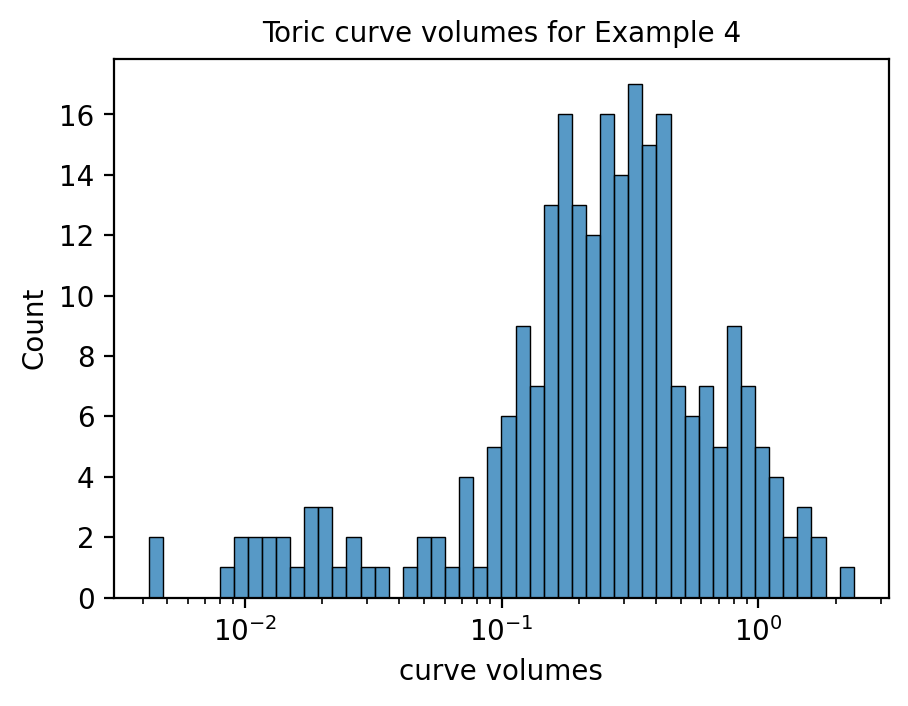

In [6]:
fig = plt.figure(dpi=200,figsize=(5,3.5))
sn.histplot(x=vols_toric,log_scale=True,bins=50)
plt.legend("",frameon=False)
plt.xlabel("curve volumes")
plt.title(f"Toric curve volumes for {str(example['paper name']).capitalize()}",fontsize=10)
plt.show()

We see that most of these curves pretty small volume which is why they need to be considered in our definition of the leading order EFT.

This is different for the potent curves. To see this, we grab the potent curve charges generating one of the potent rays and compute their volumes:

In [7]:
# Potent curve charges
potent_charges = np.array(example["potent rays charges"])

# Volumes of potent curves
vols_potent = potent_charges@kahler_st

Let us make a histogram of these volumes

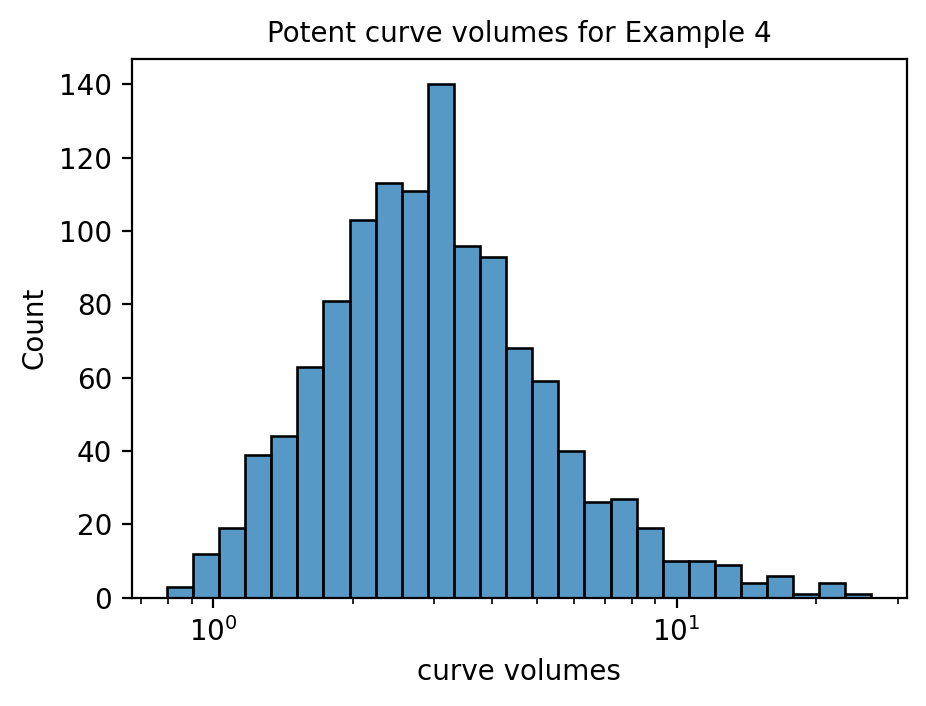

In [8]:
fig = plt.figure(dpi=200,figsize=(5,3.5))
sn.histplot(x=vols_potent,log_scale=True)
plt.legend("",frameon=False)
plt.xlabel("curve volumes")
plt.title(f"Potent curve volumes for {str(example['paper name']).capitalize()}",fontsize=10)
plt.show()

We see that most of these curves have string frame volumes well above 1. Hence, the contributions from curves are negligible.

Next, let us collect the GVs that are eithe 1 flop or 2 flop away from the phase of the extended Kähler cone in which our dS minimum lives:

In [9]:
# Grab the various types of GVs
gvs_onion0 = toric_GVs
gvs_onion1 = np.array(example["toric+1flop gvs"])
gvs_onion2 = np.array(example["toric+2flop gvs"])

Then we also collect the GVs that we obtained through random scans in lower-dimensional faces of the Mori cone as well as through a bulk GV computation using a fixed volume cutoff:

In [10]:
gvs_codim = np.array(example["codim gvs"])
gvs_bulk = np.array(example["bulk gvs"])

# Combine bulk and codim GVs
gvs_nontoric = np.append(gvs_codim,gvs_bulk,axis=0)
gvs_nontoric = np.unique(gvs_nontoric,axis=0)

Let us check the minimal string frame volume for each of these sets of GV invariants

In [11]:
# Check minimal string frame volume of curves in the corresponding sets
all_gvs = [gvs_onion0,gvs_onion1,gvs_onion2,gvs_nontoric]
for gvs in all_gvs:
    print(np.min(gvs[:,:-1]@kahler_st))

0.004244289332299367
0.004244289332299367
0.004244289332299367
0.004244289332299367


Let us next compute the volumes for each of the different layers

In [12]:
vols0 = compute_curve_volumes(gvs_onion0,kahler_st)

vols1 = compute_curve_volumes(gvs_onion1,kahler_st)

vols2 = compute_curve_volumes(gvs_onion2,kahler_st)

Let us plot these volumes here:

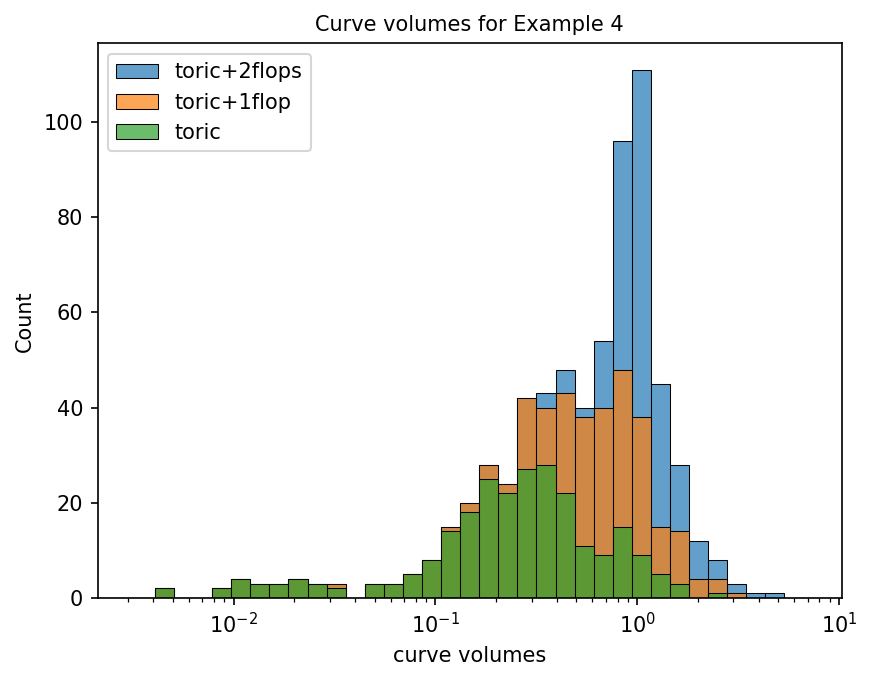

In [13]:
fig = plt.figure(dpi=150)

minx = min(vols2)/2
maxx = max(vols2)*2

bins = np.linspace(np.log10(minx), np.log10(maxx), 40)

sn.histplot(x=vols2,label="toric+2flops",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.7)
sn.histplot(x=vols1,label="toric+1flop",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.7)
sn.histplot(x=vols0,label="toric",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.7)
plt.xlim(minx,maxx)
plt.legend()
plt.xlabel("curve volumes")
plt.title(f"Curve volumes for {str(example['paper name']).capitalize()}",fontsize=10)
plt.show()

Next, we can remove the various onion layers from the list of non-toric GVs

In [14]:
charges_nontoric0 = filter_curve_charges(gvs_nontoric,gvs_onion0)
vols_nontoric0 = charges_nontoric0@kahler_st

charges_nontoric1 = filter_curve_charges(gvs_nontoric,gvs_onion1)
vols_nontoric1 = charges_nontoric1@kahler_st

charges_nontoric2 = filter_curve_charges(gvs_nontoric,gvs_onion2)
vols_nontoric2 = charges_nontoric2@kahler_st

Let us also make a histogram for these volumes

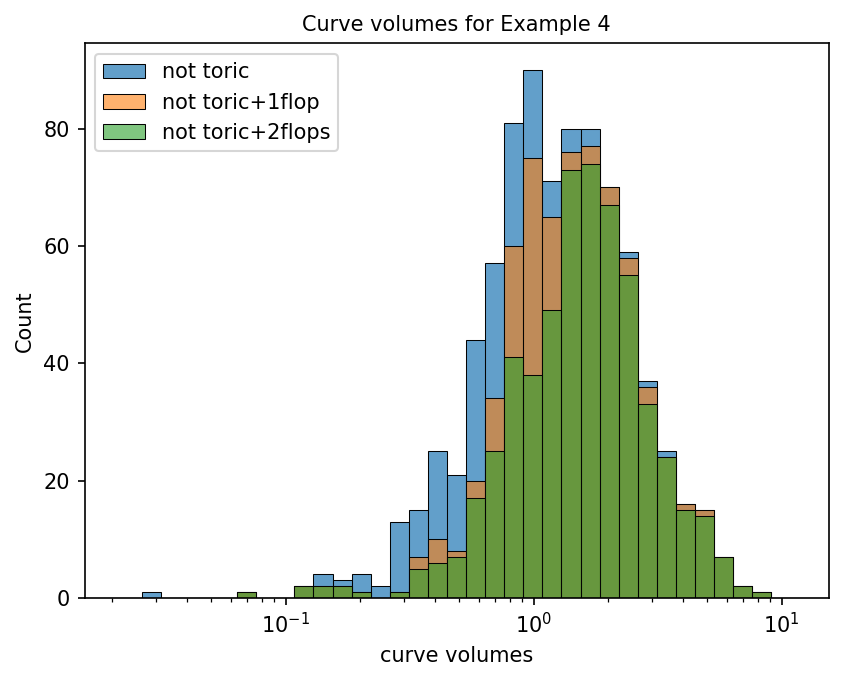

In [15]:
fig = plt.figure(dpi=150)

minx = min(vols_nontoric0)/2
maxx = max(vols_nontoric0)*2

bins = np.linspace(np.log10(minx), np.log10(maxx), 40)

sn.histplot(x=vols_nontoric0,label="not toric",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.7)
sn.histplot(x=vols_nontoric1,label="not toric+1flop",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.6)
sn.histplot(x=vols_nontoric2,label="not toric+2flops",log_scale=True,bins=bins,edgecolor=".01",linewidth=.5,alpha=0.6)
plt.xlim(minx,maxx)
plt.legend()
plt.xlabel("curve volumes")
plt.title(f"Curve volumes for {str(example['paper name']).capitalize()}",fontsize=10)
plt.show()

## Reproduce analogue of Fig. 21 (combined histogram for different layers)

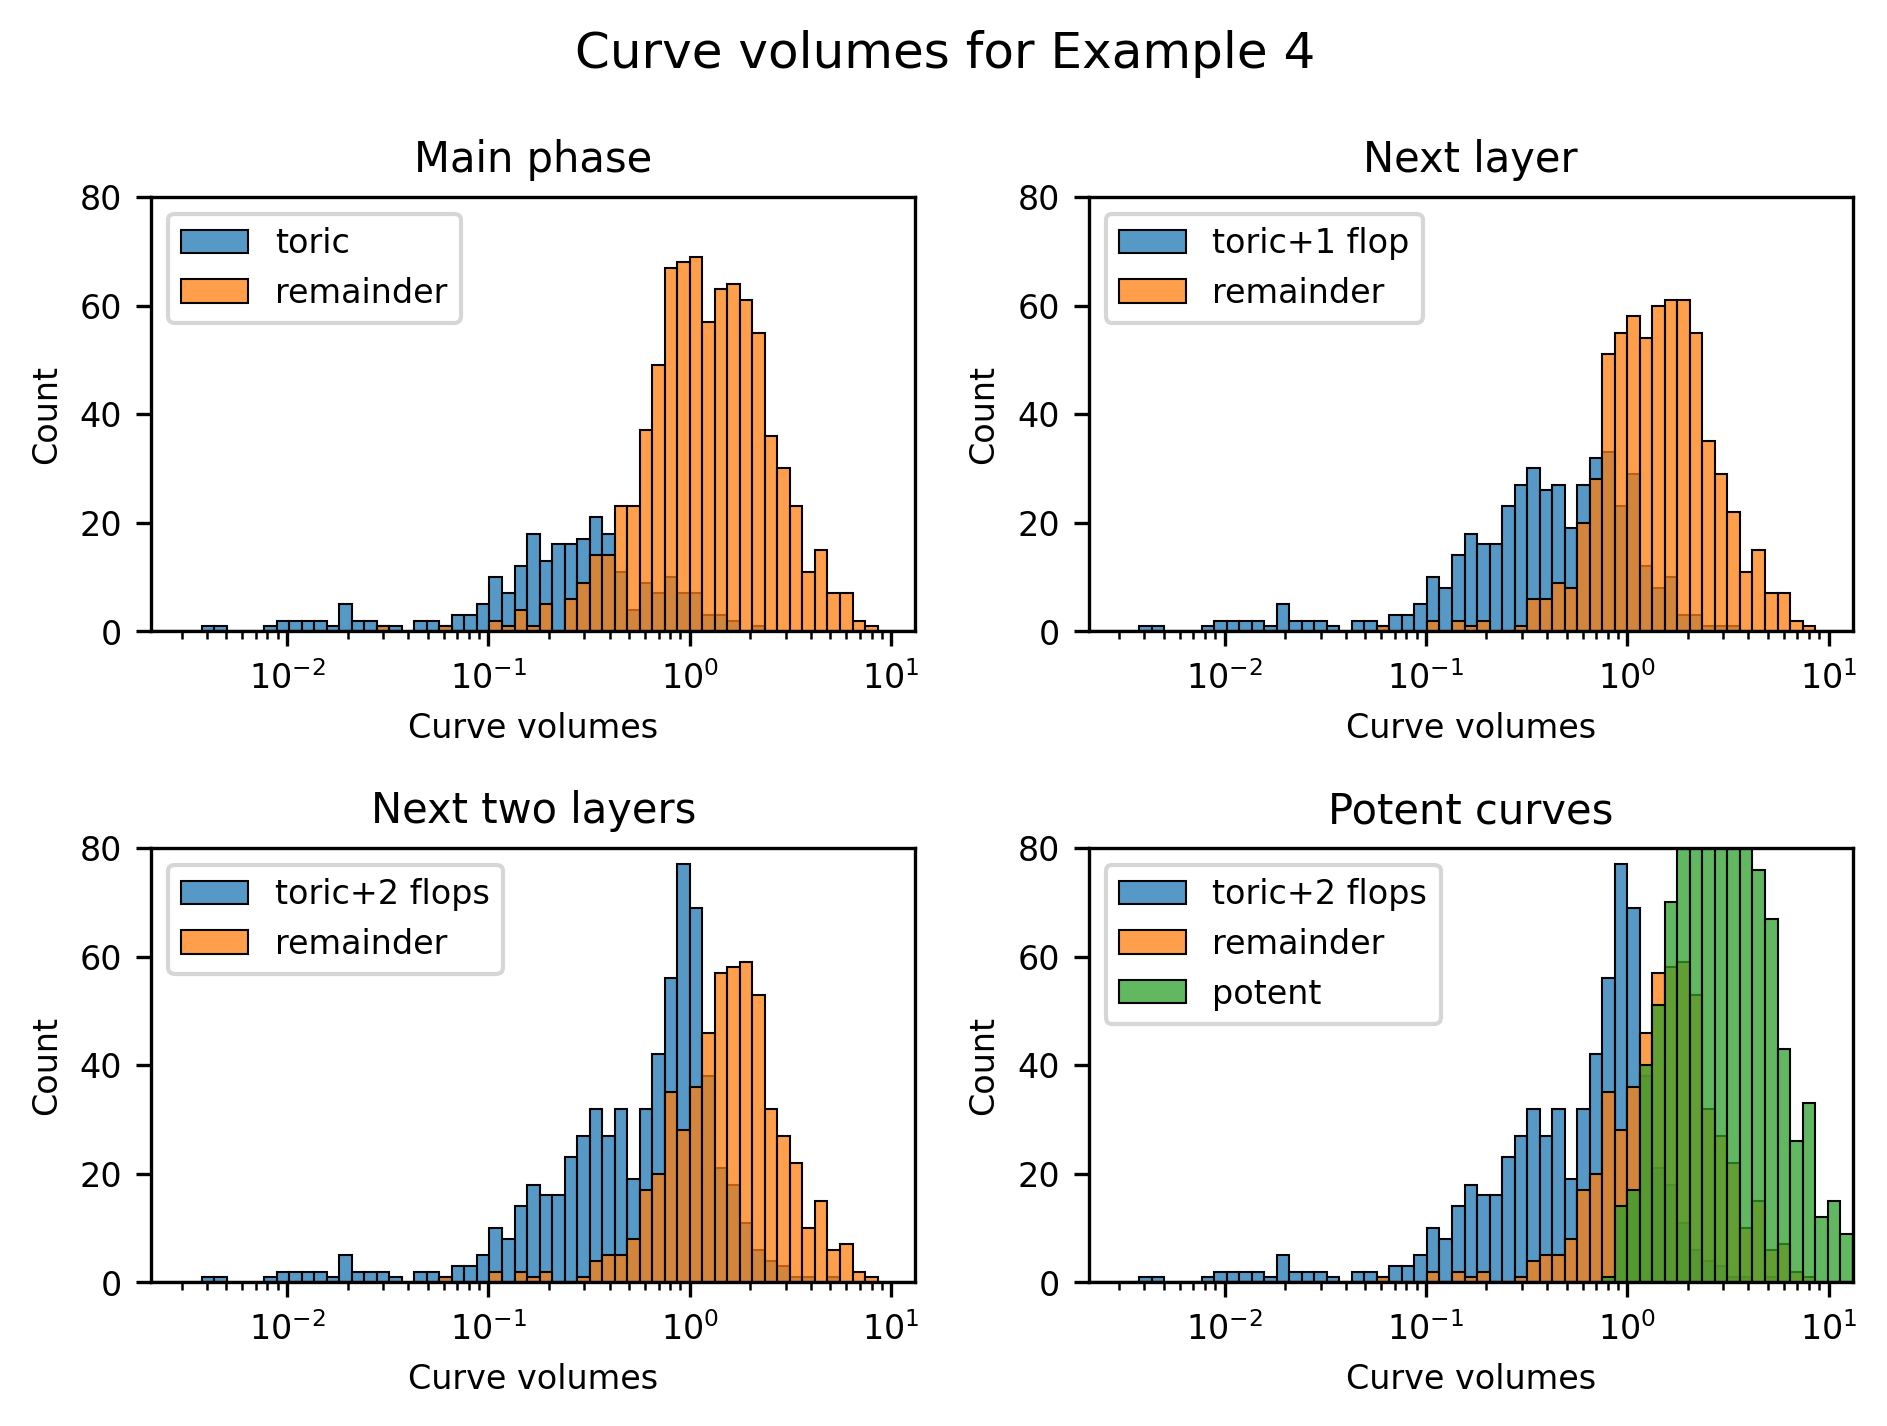

In [16]:
fig,axs = plt.subplots(2,2,dpi=300)

minx = min(vols2)/2
maxx = max(vols_potent)/2
use_log = False


bins = np.linspace(np.log10(minx), np.log10(maxx), 62)

fs_legend=8
fs_xlabel = 8
fs_suptitle=12
fs_title=10

maxy = 80
    
if use_log:
    maxy = 500

sn.histplot(x=vols0,label="toric",log_scale=True,ax=axs[0,0],bins=bins,edgecolor=".01",linewidth=.5)
sn.histplot(x=vols_nontoric0,label="remainder",log_scale=True,ax=axs[0,0],bins=bins,edgecolor=".01",linewidth=.5)
axs[0,0].legend(loc='upper left',fontsize=fs_legend)
axs[0,0].set_title("Main phase",fontsize = fs_title)
axs[0,0].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[0,0].set_ylabel("Count",fontsize = fs_xlabel)
axs[0,0].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[0,0].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

axs[0,0].set_xlim(minx,maxx)
if use_log:
    axs[0,0].set_yscale("log")
    axs[0,0].set_ylim(0.1,maxy)
else:
    axs[0,0].set_ylim(0,maxy)


sn.histplot(x=vols1,label="toric+1 flop",log_scale=True,ax=axs[0,1],bins=bins,edgecolor=".01",linewidth=.5)
sn.histplot(x=vols_nontoric1,label="remainder",log_scale=True,ax=axs[0,1],bins=bins,edgecolor=".01",linewidth=.5)
axs[0,1].legend(loc='upper left',fontsize=fs_legend)
axs[0,1].set_title("Next layer",fontsize = fs_title)
axs[0,1].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[0,1].set_ylabel("Count",fontsize = fs_xlabel)
axs[0,1].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[0,1].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

axs[0,1].set_xlim(minx,maxx)
if use_log:
    axs[0,1].set_yscale("log")
    axs[0,1].set_ylim(0.1,maxy)
else:
    axs[0,1].set_ylim(0,maxy)


sn.histplot(x=vols2,label="toric+2 flops",log_scale=True,ax=axs[1,0],bins=bins,edgecolor=".01",linewidth=.5)
sn.histplot(x=vols_nontoric2,label="remainder",log_scale=True,ax=axs[1,0],bins=bins,edgecolor=".01",linewidth=.5)
axs[1,0].legend(loc='upper left',fontsize=fs_legend)
axs[1,0].set_title("Next two layers",fontsize = fs_title)
axs[1,0].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[1,0].set_ylabel("Count",fontsize = fs_xlabel)
axs[1,0].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[1,0].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

axs[1,0].set_xlim(minx,maxx)
if use_log:
    axs[1,0].set_yscale("log")
    axs[1,0].set_ylim(0.1,maxy)
else:
    axs[1,0].set_ylim(0,maxy)



sn.histplot(x=vols2,label="toric+2 flops",log_scale=True,ax=axs[1,1],bins=bins,edgecolor=".01",linewidth=.5)
sn.histplot(x=vols_nontoric2,label="remainder",log_scale=True,ax=axs[1,1],bins=bins,edgecolor=".01",linewidth=.5)
sn.histplot(x=vols_potent,label="potent",log_scale=True,ax=axs[1,1],bins=bins,edgecolor=".01",linewidth=.5)
axs[1,1].legend(loc='upper left',fontsize=fs_legend)
axs[1,1].set_title("Potent curves",fontsize = fs_title)
axs[1,1].set_xlabel("Curve volumes",fontsize = fs_xlabel)
axs[1,1].set_ylabel("Count",fontsize = fs_xlabel)

axs[1,1].tick_params(axis='both', which='major', labelsize=fs_xlabel)
axs[1,1].tick_params(axis='both', which='minor', labelsize=fs_xlabel)

axs[1,1].set_xlim(minx,maxx)
if use_log:
    axs[1,1].set_yscale("log")
    axs[1,1].set_ylim(0.1,maxy)
else:
    axs[1,1].set_ylim(0,maxy)
    

plt.suptitle(f"Curve volumes for {str(example['paper name']).capitalize()}",fontsize = fs_suptitle)

plt.tight_layout()

plt.show()